<a href="https://colab.research.google.com/github/stevengregori92/Titanic-with-XGBoost/blob/main/Titanic_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [1]:
!pip install luwiji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.3 MB/s eta 0:00:00
  Created wheel for luwiji: filename=luwiji-1.2.1-py2.py3-none-any.whl size=40366842 sha256=b6175aa043175df8fd7be6cb0cb737bcc2d1c592f44fb90dfded9ea8c8b95269
  Stored in directory: /root/.cache/pip/wheels/1b/49/54/8dfa7de82599da47df8c290f769ade64075dc7a0a2a4fd7414
  Created wheel for jcopml: filename=jcopml-1.2.2-py2.py3-none-any.whl size=32194 sha256=dd213738839f71979c99acf03a2b80fdcb9f35dbb8da63dc8be39fcdfd7a7e20
  Stored in directory: /root/.cache/pip/wheels/a6/1c/91/32f7a6b0a9d6bbcef17a7fc0d065f9a9b8d9904551b377b64d
Successfully built luwiji jcopml


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.tuning import grid_search_params as gsp
from jcopml.plot import plot_missing_value

#Import Dataset

In [3]:
df = pd.read_csv('titanic.csv', index_col = 'PassengerId')
df.drop(columns = ['Name','Ticket','Cabin'], inplace = True)
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000,S
888,1,1,female,19.0,0,0,30.0000,S
889,0,3,female,NaN,1,2,23.4500,S


,missing_value,%
Survived,0,0.00
Pclass,0,0.00
Sex,0,0.00
Age,177,19.87
SibSp,0,0.00
Parch,0,0.00
Fare,0,0.00
Embarked,2,0.22


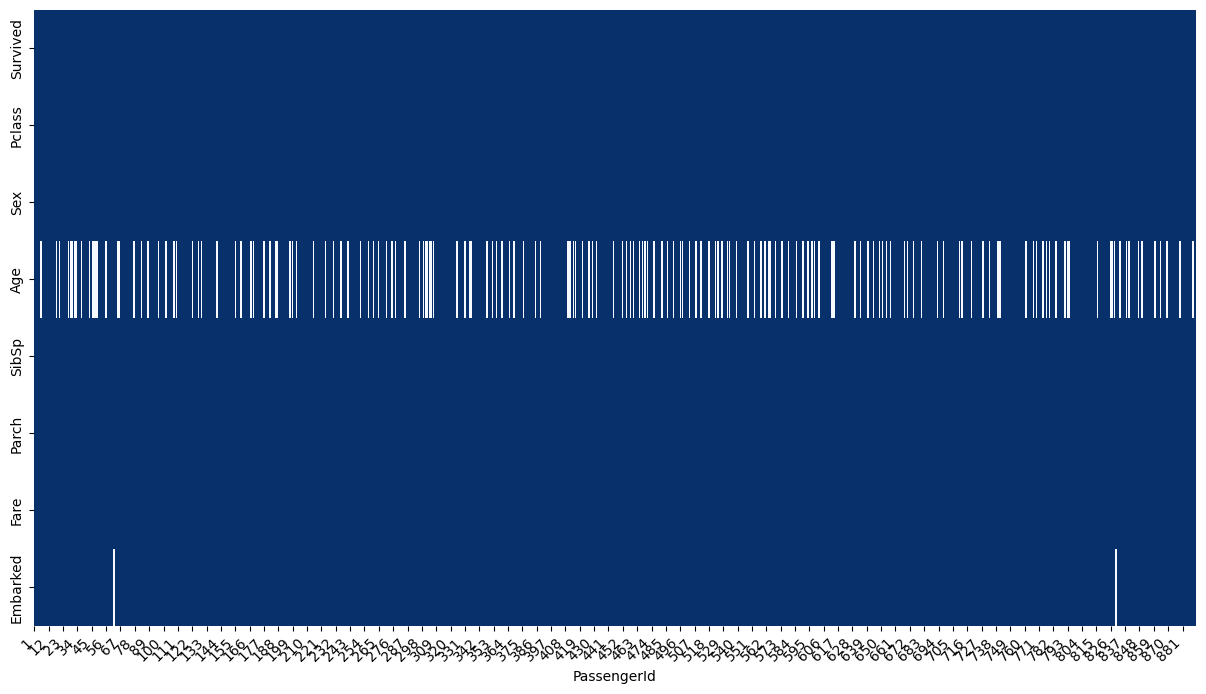

In [6]:
plot_missing_value(df, return_df=True)

#Data Splitting

In [7]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [8]:
X = df.drop(columns=['Survived'])
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 7), (179, 7), (712,), (179,))

#Normal

In [14]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [16]:
#Preprocessing
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ['Parch', 'SibSp', 'Age', 'Fare']),
    ('categoric', cat_pipe(encoder = 'onehot'), ['Pclass', 'Sex', 'Embarked'])
])

#Pipeline
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs = -1, random_state = 42))
])

#Training
model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=100, n_jobs=-1, verbose = 1, random_state = 42)
model.fit(X_train, y_train)

#Evaluate
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_,model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'algo__colsample_bytree': 0.5967161548970371, 'algo__gamma': 5, 'algo__learning_rate': 0.015025068018515657, 'algo__max_depth': 9, 'algo__n_estimators': 116, 'algo__reg_alpha': 0.0034360613844702597, 'algo__reg_lambda': 0.0013035590385085064, 'algo__subsample': 0.6775686278368096}
0.8595505617977528 0.8300712690139348 0.7988826815642458


#Polynomial

In [17]:
from jcopml.feature_importance import mean_score_decrease

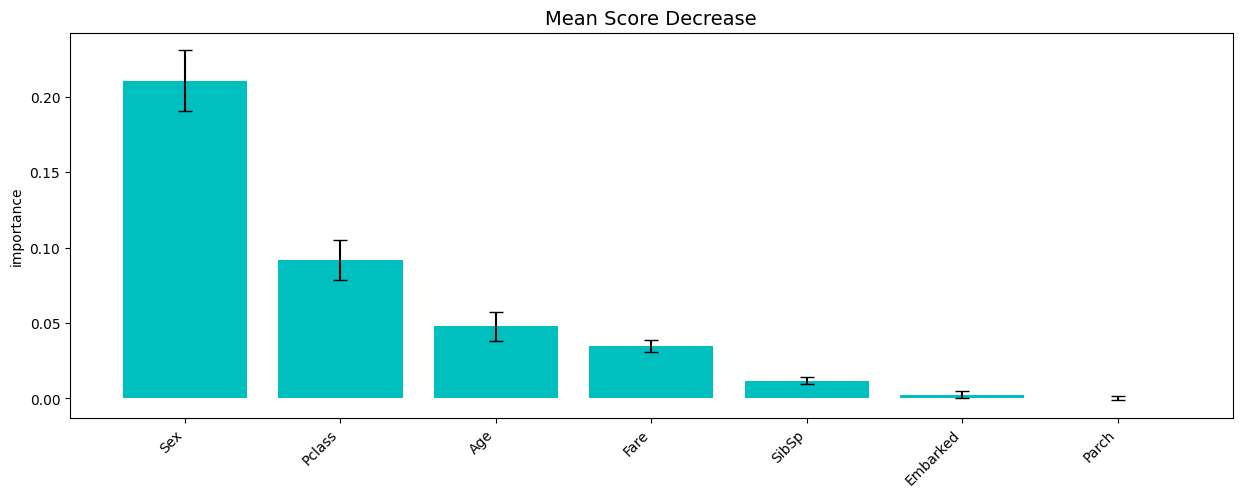

In [18]:
data_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk = 10)

In [20]:
#Preprocessing
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['SibSp', 'Age', 'Fare']),
    ('categoric', cat_pipe(encoder = 'onehot'), ['Pclass', 'Sex'])
])

#Pipeline
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

#Training
model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=3, n_iter = 100, n_jobs=-1, verbose = 1, random_state=42)
model.fit(X_train, y_train)

#Evaluation
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_,model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'algo__colsample_bytree': 0.9403226413838872, 'algo__gamma': 5, 'algo__learning_rate': 0.015979564727084544, 'algo__max_depth': 6, 'algo__n_estimators': 169, 'algo__reg_alpha': 0.009634538433595985, 'algo__reg_lambda': 0.004392638796750215, 'algo__subsample': 0.39328351202565287, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': False}
0.8651685393258427 0.8342906782966351 0.8100558659217877
